<a href="https://colab.research.google.com/github/deniseiras/Artificial-Intelligence/blob/main/CAP_421_Data_Augmentation_Denis_Eiras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the EuroSAT database

## Download and load the database

The following code is based on a tutorial to download and load the [EuroSAT](https://github.com/phelber/eurosat) database,  available at [this link](https://colab.research.google.com/github/e-chong/Remote-Sensing/blob/master/EuroSAT%20Land%20Cover%20Classification/EuroSAT%20Land%20Use%20and%20Land%20Cover%20Classification%20using%20Deep%20Learning.ipynb#scrollTo=IppT1bDRQKge).

In [ ]:
import zipfile
import requests
import io
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])
N = len(XImages)

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  i += 1

del r # clear memory
del z 

The following lines create the variables `labels` and `yLabels`, storing class names and numbers.

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


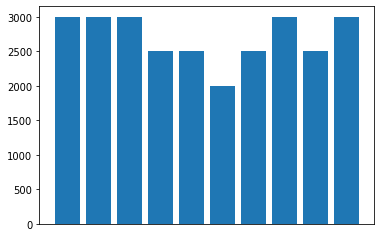

In [ ]:
# get labels in numpy array as strings
labels = []
for label in txtfiles:
  labels.append(label.split('/')[1])
  
# change them to integers in alphabetical order
label_names, yLabels = np.unique(labels, return_inverse=True)
label_dictionary = dict(zip(np.unique(yLabels), label_names))

# show number of samples per class
print(label_dictionary)
plt.hist(yLabels, rwidth=0.8)
plt.xticks([])
plt.show()

## How to view sample examples and corresponding labels
This database is composed by 27000 samples, with 64x64 pixels and 3 bands (red, green, blue). The images/labels can be accessed by the first index of both `XImages` and `labels` variables.

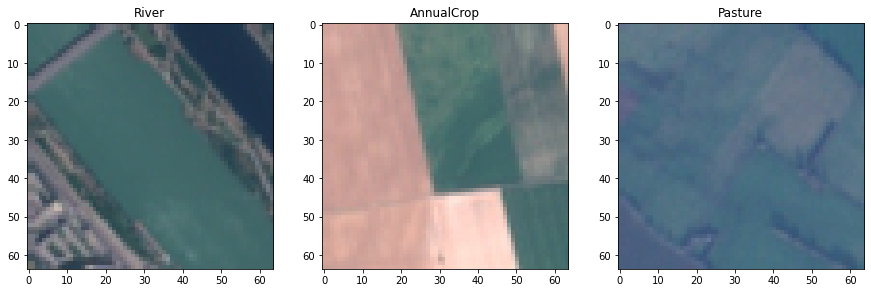

In [ ]:
plt.figure(figsize=(15, 5))

index = 100
plt.subplot(131)
plt.imshow(XImages[index])
plt.title(labels[index])

index = 4000
plt.subplot(132)
plt.imshow(XImages[index])
plt.title(labels[index])

index = 16500
plt.subplot(133)
plt.imshow(XImages[index])
plt.title(labels[index])

plt.show()

Lets check how to view the 3D feature space for one RBG image.

In [ ]:
# display video about spatial filtering
%%HTML
<center><iframe width="800" height="500" src="https://www.youtube.com/embed/lGh_zCyY7TY?start=87" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>

We can show the scatterplot for all samples of class `Pasture`, with less samples then the other classes.

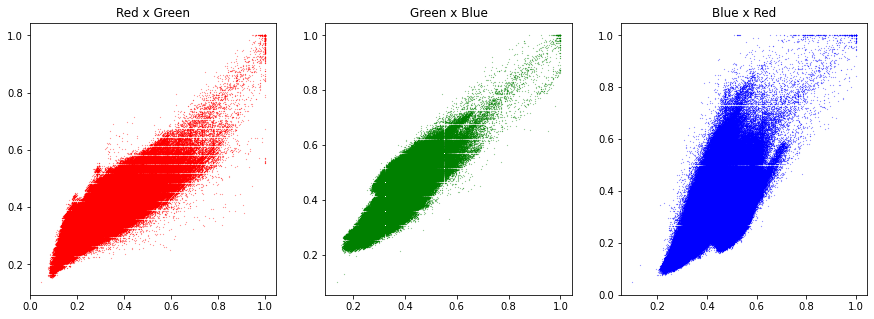

In [ ]:
# according to the histogram of class occurrences,
# the class Pasture, number 5, contains less samples (2000)
less_samples_label = label_names[5]
less_samples_indices = []

vector_R = []
vector_G = []
vector_B = []

for i in range(N):
  if labels[i] == less_samples_label:
    vector_R.append(XImages[i][:,:,0].flatten())
    vector_G.append(XImages[i][:,:,1].flatten())
    vector_B.append(XImages[i][:,:,2].flatten())
    less_samples_indices.append(i)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='r')
plt.title('Red x Green')

plt.subplot(132)
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='g')
plt.title('Green x Blue')

plt.subplot(133)
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='b')
plt.title('Blue x Red')

plt.show()

## Divide database into train/test sets

We now divide the `XImages` + `yLabels` dataset into `X_train` + `y_train` and `X_test` + `y_test` datasets, that will be used to compare each other in the classification experiments.

In [ ]:
from sklearn.model_selection import train_test_split

# create X_train -> y_train, and X_test -> y_test
X_train, X_test, y_train, y_test = train_test_split(XImages, 
                                                    yLabels, 
                                                    stratify = yLabels, 
                                                    train_size = 0.25, 
                                                    random_state = 42)

print('len(XImages):', len(XImages), 'len(yLabels):', len(yLabels))
print('len(X_train):', len(X_train), 'len(y_train):', len(y_train))
print('len(X_test):', len(X_test), 'len(y_test):', len(y_test))

len(XImages): 27000 len(yLabels): 27000
len(X_train): 6750 len(y_train): 6750
len(X_test): 20250 len(y_test): 20250


# Data Augmentation (DA)

According to [chollet2018], DA generates more training data from existing training samples, and the goal is that at training time, classification models will never see the exact same sample twice, exposing the model to more aspects of the data and generalize better.

However, the inputs are still heavily intercorrelated, because they come from a small number of original images. With DA there is no new information, it is only a remix of existing information. 

Some operations are based on [tensorflow2021da].

## DA with Rotation
This technique will rotate the image with random angles.
`factor=0.2` results in an output rotating by a random amount in the range `[-20% * 2pi, 20% * 2pi]`.

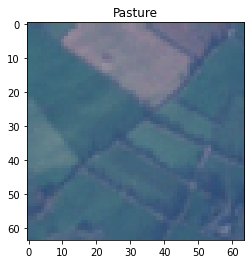

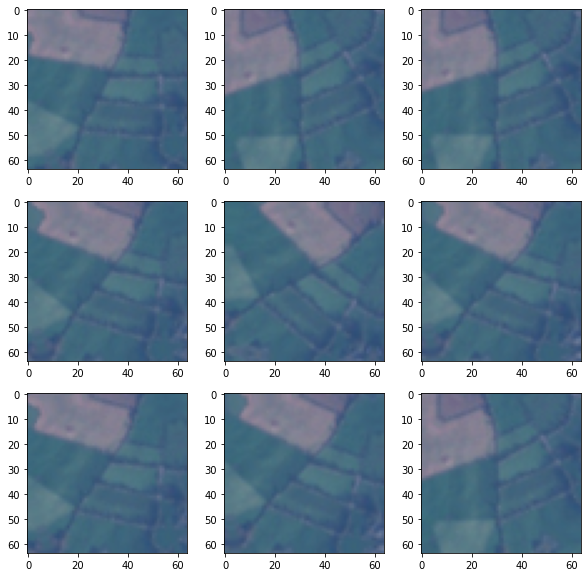

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

DA_rotation = tf.keras.Sequential([
  layers.RandomRotation(0.2),
])

# get one image of class 'Pasture'
index = 150
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_rotation(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

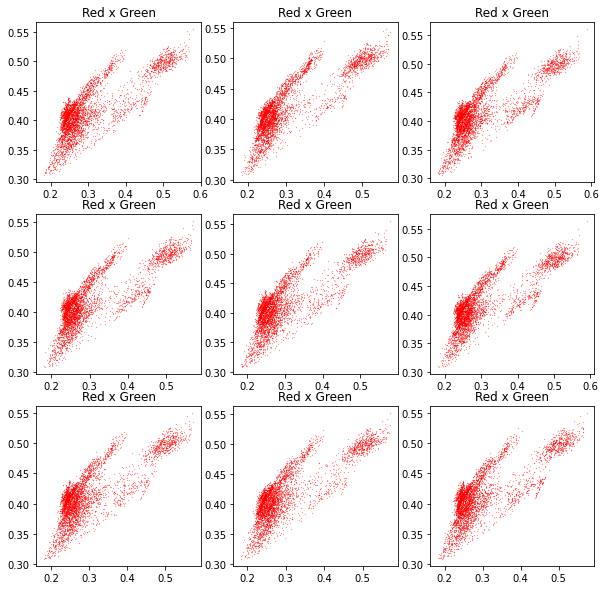

In [ ]:
# incluir scatterplot original

# view scatterplots of various rotations
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_rotation(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.title('Red x Green')

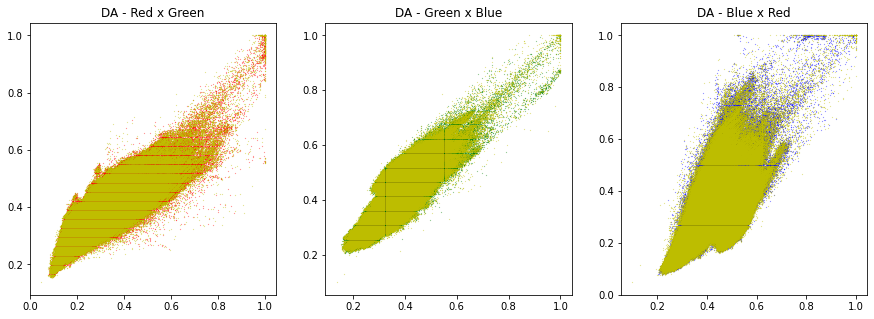

In [ ]:
# apply DA to all Pasture images in XImages
RotationImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  RotationImages[i] = DA_rotation(XImages[sample_index])

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(RotationImages[i][:,:,0].flatten())
  vector_G_DA.append(RotationImages[i][:,:,1].flatten())
  vector_B_DA.append(RotationImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('DA - Blue x Red')

plt.show()

## DA with Flip
This technique will flip the image, horizontally or vertically.

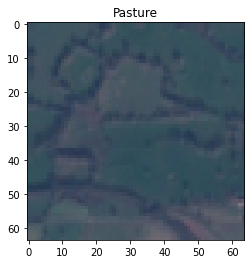

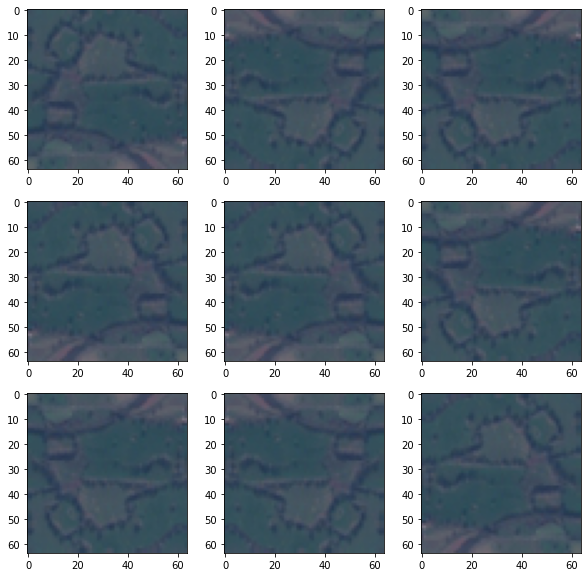

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

DA_flip = tf.keras.Sequential([
  layers.RandomFlip('horizontal_and_vertical'),
])

# get one image of class 'Pasture'
index = 190
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_flip(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

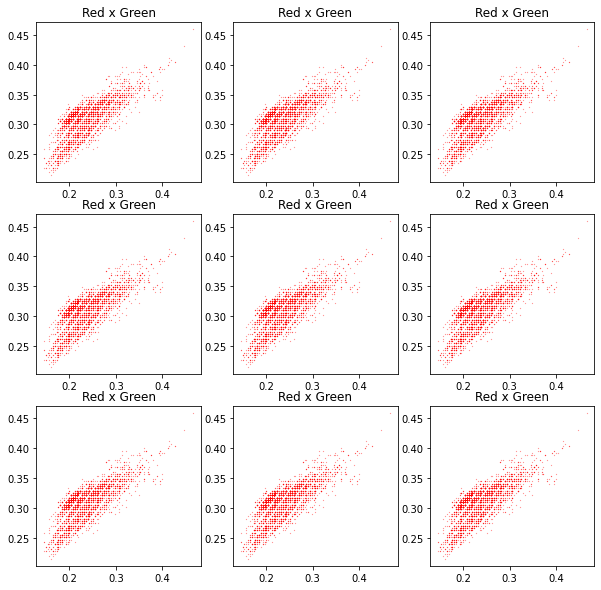

In [ ]:
# view scatterplots of various flips
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_flip(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.title('Red x Green')

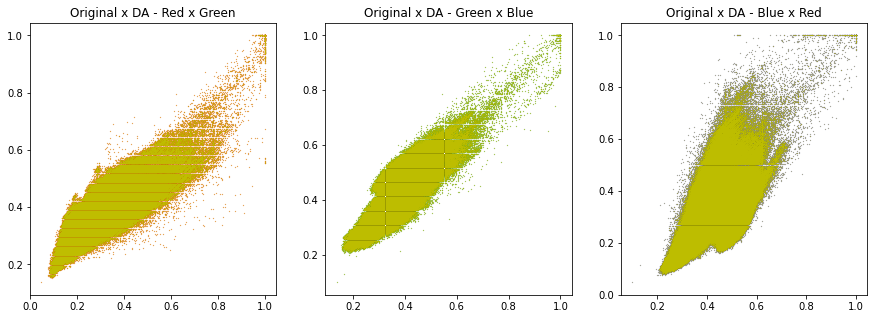

In [ ]:
# apply DA to all Pasture images in XImages
FlipImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  FlipImages[i] = DA_flip(XImages[sample_index])

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(FlipImages[i][:,:,0].flatten())
  vector_G_DA.append(FlipImages[i][:,:,1].flatten())
  vector_B_DA.append(FlipImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

## DA with Zoom

A positive value of factor means zooming out, while a negative value means zooming in, for `height` and/or `width`.

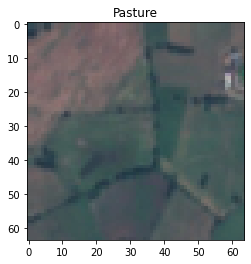

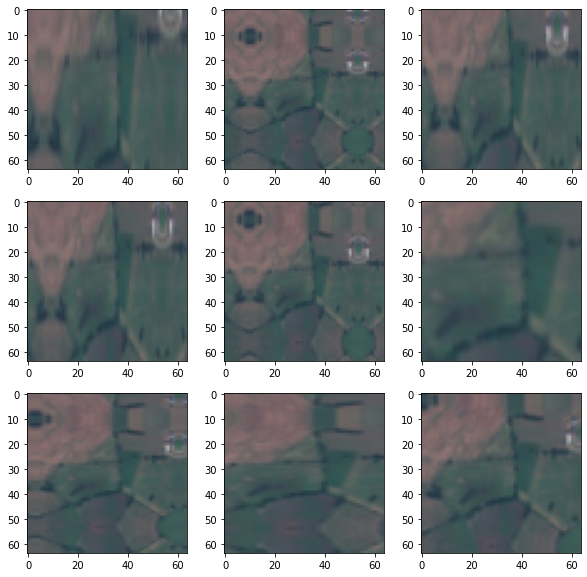

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

DA_zoom = tf.keras.Sequential([
  layers.RandomZoom(0.6, 0.5),
])

# get one image of class 'Pasture'
index = 650
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_zoom(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

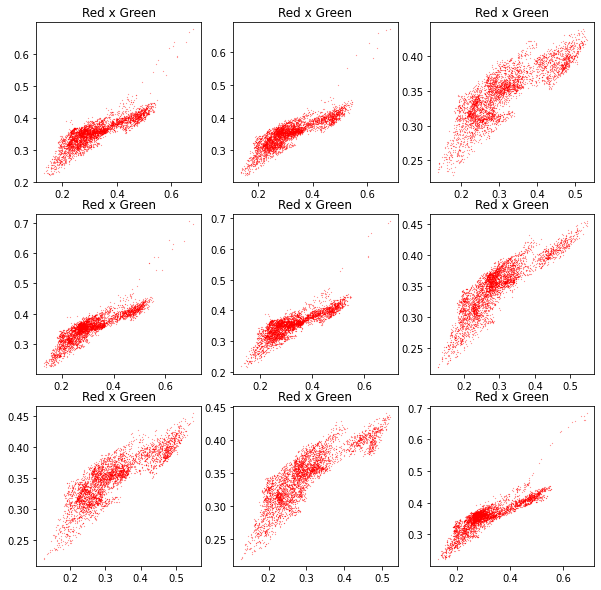

In [ ]:
# view scatterplots of various zoom levels 
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_zoom(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  # plt.xlim([0, 1]), plt.ylim([0, 1]) ???
  plt.title('Red x Green')

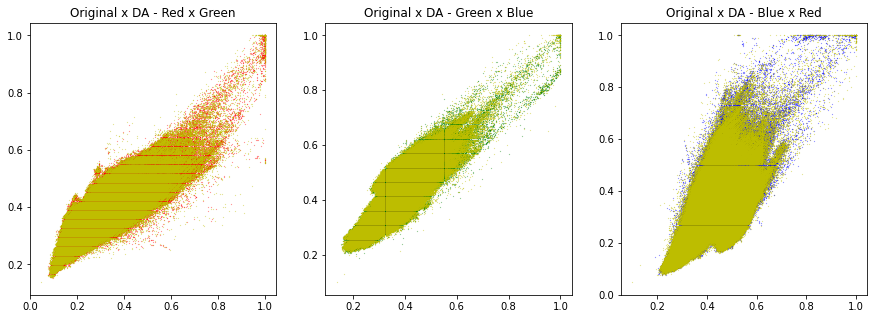

In [ ]:
# apply DA to all Pasture images in XImages
ZoomImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  ZoomImages[i] = DA_zoom(XImages[sample_index])

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(ZoomImages[i][:,:,0].flatten())
  vector_G_DA.append(ZoomImages[i][:,:,1].flatten())
  vector_B_DA.append(ZoomImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

## DA with Contrast

This technique will adjust the contrast of the image,  by a random factor, `[1 - factor, 1 + factor]`.

In [ ]:
# display video about spatial filtering
%%HTML
<center><iframe width="800" height="500" src="https://www.youtube.com/embed/XT_rMDMDEvo?start=217" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


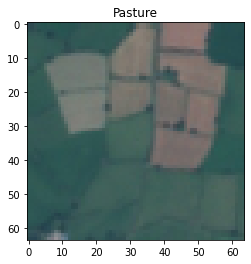

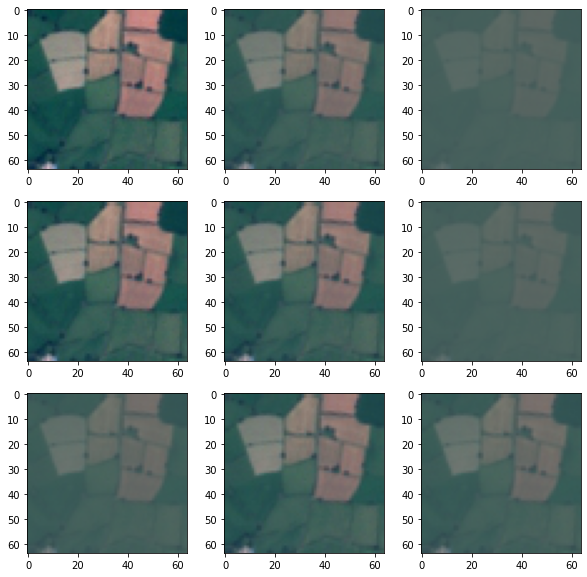

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

DA_contrast = tf.keras.Sequential([
  layers.RandomContrast(0.9),
])

# get one image of class 'Pasture'
index = 350
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_contrast(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

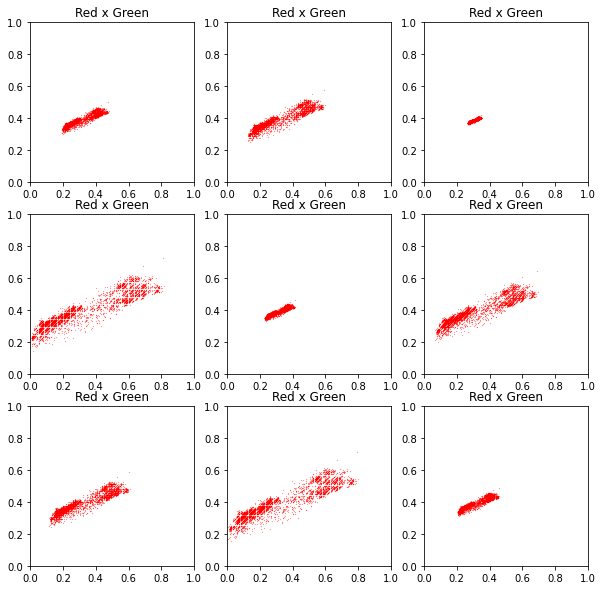

In [ ]:
# view scatterplots of various contrasts 
# (check differences between the plots)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = DA_contrast(input_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.xlim([0, 1]), plt.ylim([0, 1])
  plt.title('Red x Green')

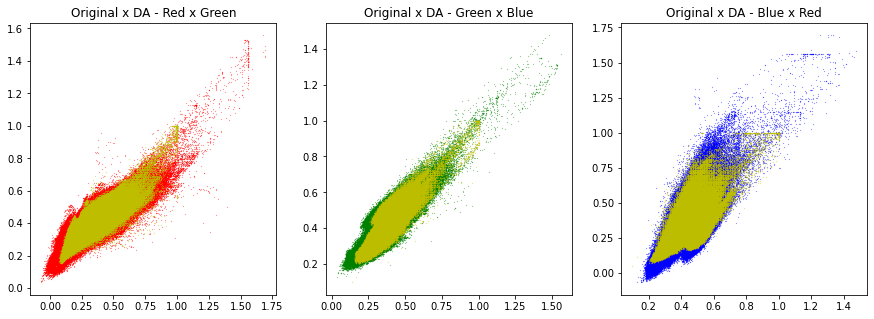

In [ ]:
# apply DA to all Pasture images in XImages
ContrastImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  ContrastImages[i] = DA_contrast(XImages[sample_index])

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(ContrastImages[i][:,:,0].flatten())
  vector_G_DA.append(ContrastImages[i][:,:,1].flatten())
  vector_B_DA.append(ContrastImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

## DA with Brightness

This technique will adjust the brightness of images by a random factor deterministically.

In [ ]:
# display video about spatial filtering
%%HTML
<center><iframe width="800" height="500" src="https://www.youtube.com/embed/XT_rMDMDEvo?start=177" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>

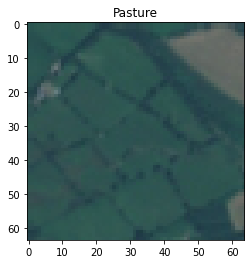

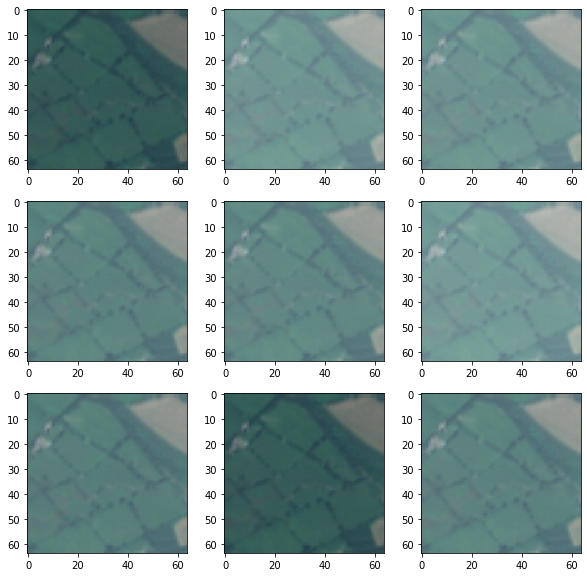

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# this function will use tf.image module
# so we will create a factor to be used
# with np.random
factor = 0.3

# get one image of class 'Pasture'
index = 950
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  delta = factor * np.random.rand()
  augmented_image = tf.image.adjust_brightness(input_image, delta)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

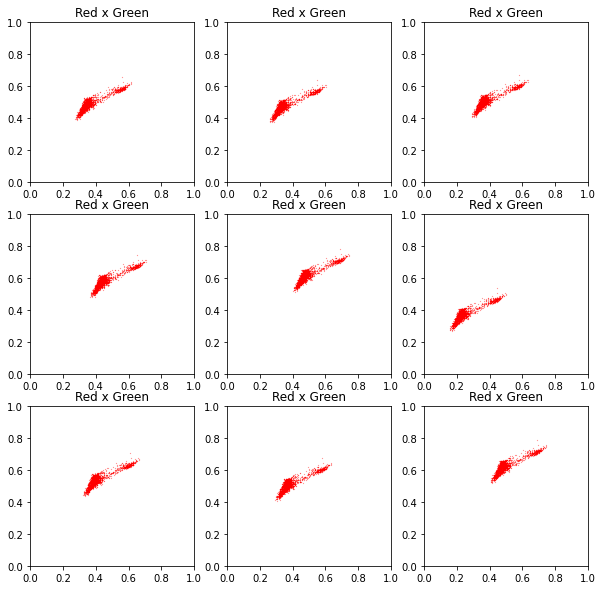

In [ ]:
# view scatterplots of various brightness 
# (check differences between the plots)
plt.figure(figsize=(10, 10))
for i in range(9):
  delta = factor * np.random.rand()
  augmented_image = tf.image.adjust_brightness(input_image, delta)
  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.xlim([0, 1]), plt.ylim([0, 1])
  plt.title('Red x Green')

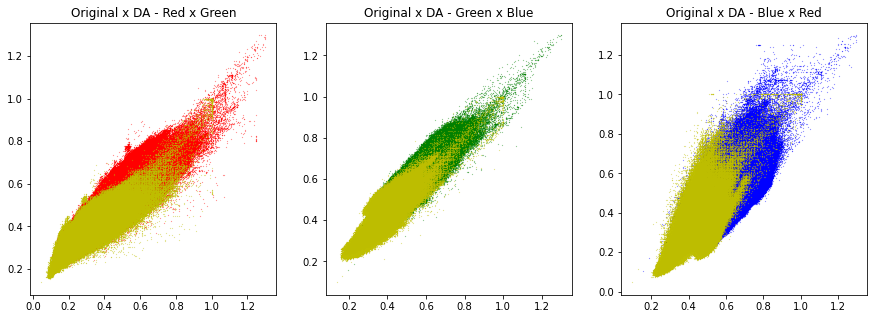

In [ ]:
# apply DA to all images in XImages
BrightnessImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  delta = factor * np.random.rand()
  BrightnessImages[i] = tf.image.adjust_brightness(XImages[sample_index], delta)

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(BrightnessImages[i][:,:,0].flatten())
  vector_G_DA.append(BrightnessImages[i][:,:,1].flatten())
  vector_B_DA.append(BrightnessImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

## DA with Hue

This technique will adjust the hue of RGB images by a random factor deterministically.

In [ ]:
# display video about spatial filtering
%%HTML
<center><iframe width="800" height="500" src="https://www.youtube.com/embed/NAw2_NtGNaA?start=79" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>

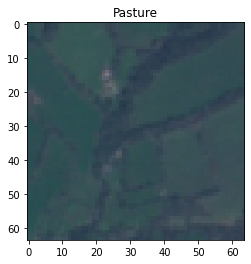

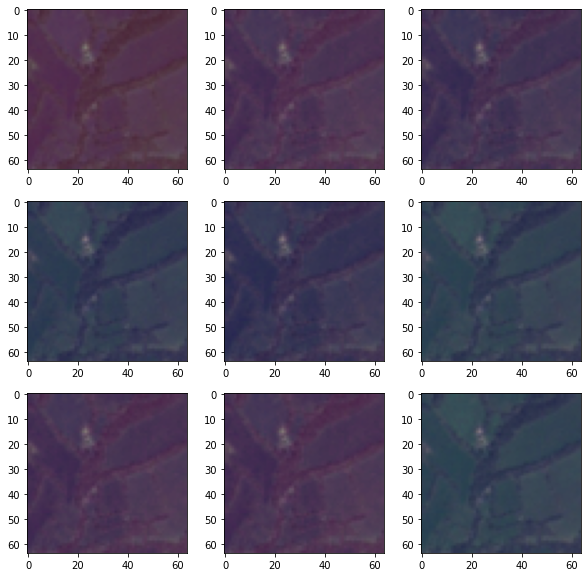

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# this function will use tf.image module
# so we will create a factor to be used
# with np.random
factor = 0.5
seed = (1, 2)

# get one image of class 'Pasture'
index = 1850
sample_index = less_samples_indices[index]
input_image = XImages[sample_index]

plt.figure()
plt.imshow(input_image)
plt.title(labels[sample_index])

# apply various rotations in the same image
plt.figure(figsize=(10, 10))
for i in range(9):
  delta = factor * np.random.rand()
  augmented_image = tf.image.stateless_random_hue(input_image, delta, seed)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)

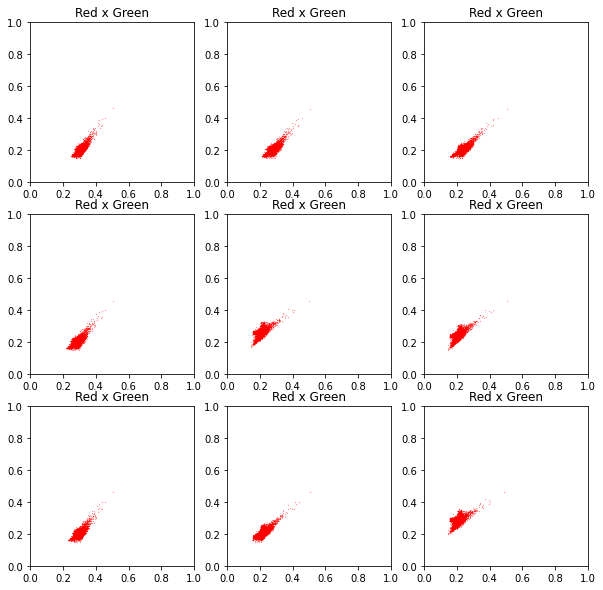

In [ ]:
# view scatterplots of various hue adjustments 
# (check differences between the plots)
plt.figure(figsize=(10, 10))
for i in range(9):
  delta = factor * np.random.rand()
  augmented_image = tf.image.stateless_random_hue(input_image, delta, seed)

  ax = plt.subplot(3, 3, i + 1)
  plt.scatter(augmented_image[:,:,0], augmented_image[:,:,1], s=0.1, marker='.', c='r')
  plt.xlim([0, 1]), plt.ylim([0, 1])
  plt.title('Red x Green')

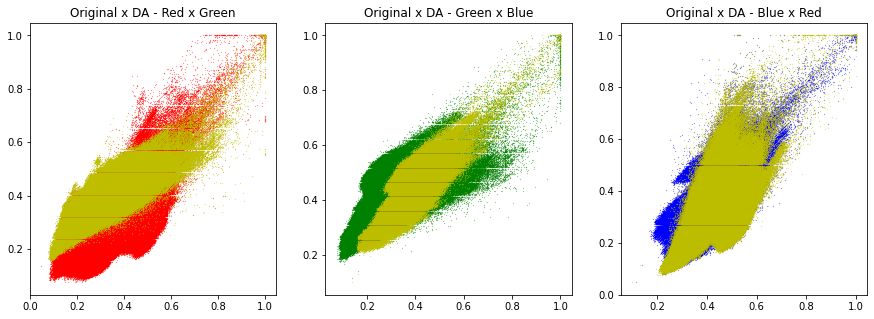

In [ ]:
# apply DA to all Pasture images in XImages
HueImages = np.zeros([len(less_samples_indices), 64, 64, 3])

for i in range(len(less_samples_indices)):
  sample_index = less_samples_indices[i]
  delta = factor * np.random.rand()
  HueImages[i] = tf.image.stateless_random_hue(XImages[sample_index], delta, seed)

vector_R_DA = []
vector_G_DA = []
vector_B_DA = []

for i in range(len(less_samples_indices)):
  vector_R_DA.append(HueImages[i][:,:,0].flatten())
  vector_G_DA.append(HueImages[i][:,:,1].flatten())
  vector_B_DA.append(HueImages[i][:,:,2].flatten())

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(vector_R_DA, vector_G_DA, s=0.1, marker='.', c='r')
plt.scatter(vector_R, vector_G, s=0.1, marker='.', c='y')
plt.title('Original x DA - Red x Green')

plt.subplot(132)
plt.scatter(vector_G_DA, vector_B_DA, s=0.1, marker='.', c='g')
plt.scatter(vector_G, vector_B, s=0.1, marker='.', c='y')
plt.title('Original x DA - Green x Blue')

plt.subplot(133)
plt.scatter(vector_B_DA, vector_R_DA, s=0.1, marker='.', c='b')
plt.scatter(vector_B, vector_R, s=0.1, marker='.', c='y')
plt.title('Original x DA - Blue x Red')

plt.show()

# Compare CNN with Original x DA datasets

We will perform 3 experiments: 
* The first is a CNN trained with only `X_train` dataset. 
* In the second experiment we derive the `X_train_DA` dataset, with some (*rotation*, *flip*, *zoom*, and *contrast*) DA applied (and therefore more 2x samples than the original).
* The third experiment uses `X_train` dataset to derive the `X_train_DA2` dataset, with remaining (*brightness* and *hue*) DA applied.

**Note:** *According to [chollet2018] the validation data shouldn’t be augmented.*

## Creating the model without DA
We will create a simple classification model, based on [tensorflow2021images], to compare the use (or not) of DA in training.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(label_dictionary)
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(
  X_train, y_train,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test)
)

Epoch 1/30
211/211 [==============================] - 19s 16ms/step - loss: 1.6140 - accuracy: 0.3575 - val_loss: 1.3580 - val_accuracy: 0.4549
Epoch 2/30
211/211 [==============================] - 2s 10ms/step - loss: 1.1827 - accuracy: 0.5484 - val_loss: 1.0078 - val_accuracy: 0.6304
Epoch 3/30
211/211 [==============================] - 2s 10ms/step - loss: 0.9829 - accuracy: 0.6363 - val_loss: 0.9959 - val_accuracy: 0.6224
Epoch 4/30
211/211 [==============================] - 2s 9ms/step - loss: 0.8628 - accuracy: 0.6831 - val_loss: 0.7733 - val_accuracy: 0.7242
Epoch 5/30
211/211 [==============================] - 2s 9ms/step - loss: 0.7954 - accuracy: 0.7083 - val_loss: 0.7476 - val_accuracy: 0.7266
Epoch 6/30
211/211 [==============================] - 2s 9ms/step - loss: 0.7065 - accuracy: 0.7369 - val_loss: 0.6675 - val_accuracy: 0.7642
Epoch 7/30
211/211 [==============================] - 2s 9ms/step - loss: 0.7171 - accuracy: 0.7342 - val_loss: 0.7094 - val_accuracy: 0.7387
Ep

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)             

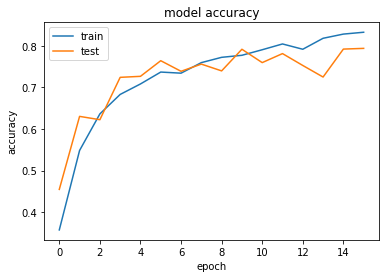

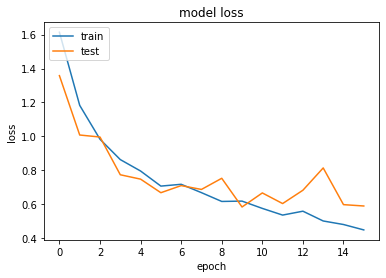

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Classify some random elements to test the model.

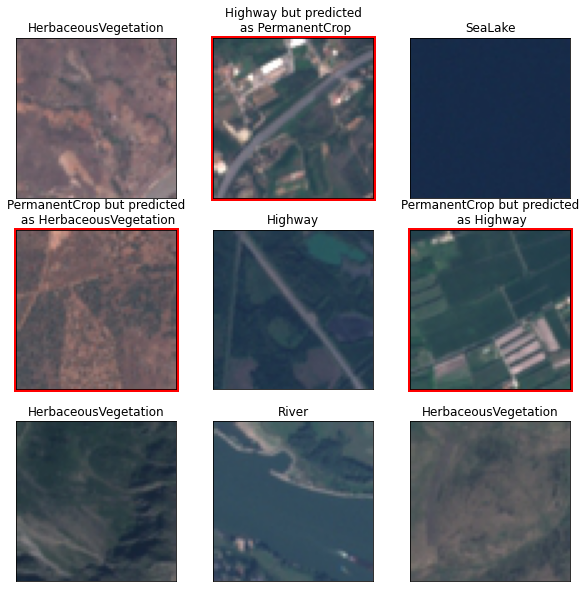

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


## Creating the model with some DA
In this test, we will apply 4 DA techniques, available in `tf.keras.Sequential`:
* Rotation
* Flip
* Zoom
* Contrast

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(label_dictionary)
model_DA = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model_DA.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

This block will apply DA to the data, and append the samples to `X_train` and `y_train` data, creating `X_train_DA` and `y_train_DA` items.

In [ ]:
DA_techniques = tf.keras.Sequential([
  layers.RandomRotation(0.2),
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomZoom(0.6, 0.5),
  layers.RandomContrast(0.9),
])

# apply DA to all images in X_train
X_train_DA = np.zeros([2 * len(X_train), 64, 64, 3])
y_train_DA = np.zeros([2 * len(y_train)])

# insert DA elements first
for i in range(len(X_train)):
  X_train_DA[i] = DA_techniques(X_train[i])
  y_train_DA[i] = y_train[i]

# insert original elements to X_train_DA
X_train_DA[len(X_train):] = X_train
y_train_DA[len(y_train):] = y_train

print(len(X_train))
print(len(y_train))
print(len(X_train_DA))
print(len(y_train_DA))

6750
6750
13500
13500


In [ ]:
history_DA = model_DA.fit(
  X_train_DA, y_train_DA,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test)
)

Epoch 1/30
422/422 [==============================] - 4s 9ms/step - loss: 1.6336 - accuracy: 0.3610 - val_loss: 1.3326 - val_accuracy: 0.5229
Epoch 2/30
422/422 [==============================] - 3s 6ms/step - loss: 1.2448 - accuracy: 0.5492 - val_loss: 0.9920 - val_accuracy: 0.6500
Epoch 3/30
422/422 [==============================] - 3s 6ms/step - loss: 1.0677 - accuracy: 0.6142 - val_loss: 0.9701 - val_accuracy: 0.6556
Epoch 4/30
422/422 [==============================] - 3s 6ms/step - loss: 1.0066 - accuracy: 0.6318 - val_loss: 0.9014 - val_accuracy: 0.6812
Epoch 5/30
422/422 [==============================] - 3s 6ms/step - loss: 0.9494 - accuracy: 0.6576 - val_loss: 0.7561 - val_accuracy: 0.7293
Epoch 6/30
422/422 [==============================] - 3s 6ms/step - loss: 0.9073 - accuracy: 0.6710 - val_loss: 0.8189 - val_accuracy: 0.7052
Epoch 7/30
422/422 [==============================] - 3s 6ms/step - loss: 0.8599 - accuracy: 0.6916 - val_loss: 0.6728 - val_accuracy: 0.7555
Epoch 

Lets compare the plots of accuracy and loss along the epochs, without and with DA.

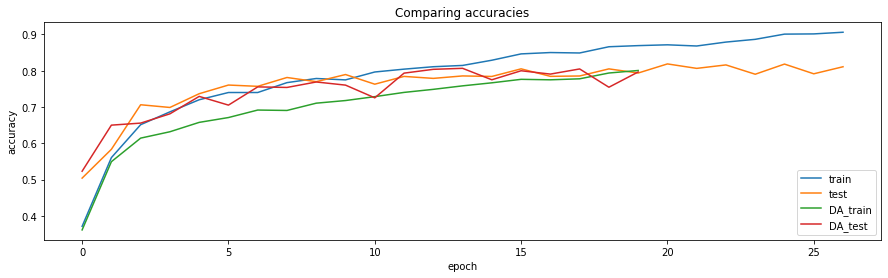

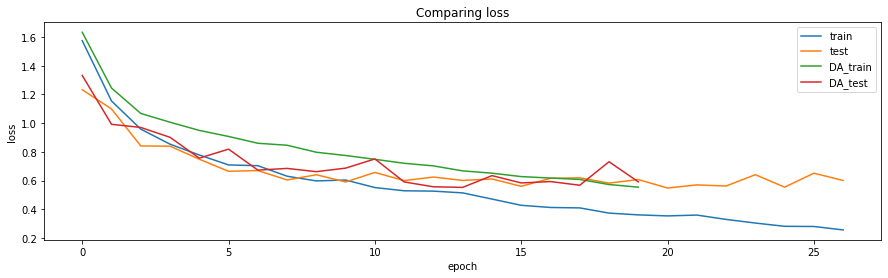

In [ ]:
plt.figure(figsize=(15, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_DA.history['accuracy'])
plt.plot(history_DA.history['val_accuracy'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='lower right')
plt.title('Comparing accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

plt.figure(figsize=(15, 4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_DA.history['loss'])
plt.plot(history_DA.history['val_loss'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='upper right')
plt.title('Comparing loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Classify some random elements to test the model.

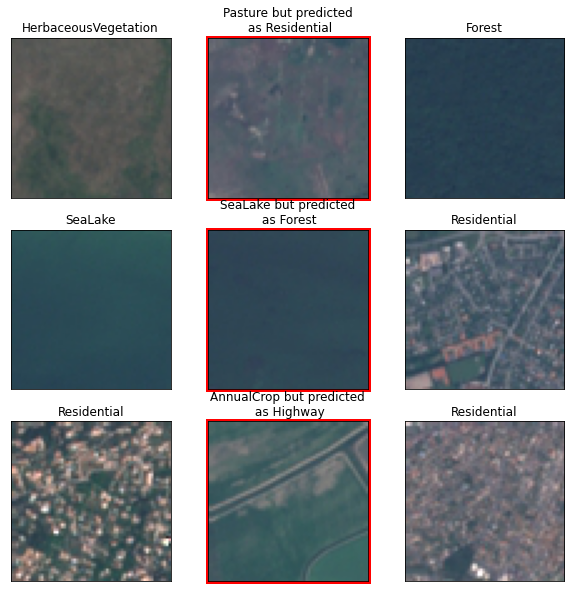

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model_DA.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predict = model.predict(X_test)
print('Confusion Matrix and Report for model without DA')
print(confusion_matrix(y_test, predict.argmax(axis=1)))
print(classification_report(y_test, predict.argmax(axis=1)))

print('Confusion Matrix and Report with some DA')
predict_DA = model_DA.predict(X_test)
print(confusion_matrix(y_test, predict_DA.argmax(axis=1)))
print(classification_report(y_test, predict_DA.argmax(axis=1)))

Confusion Matrix and Report for model without DA
[[1745   15   28   74    0  120  109    1  141   17]
 [   0 2177   19    3    0   37    0    0   13    1]
 [  24   15 1658   63   62   51  218  119   33    7]
 [  54    7   88 1110  126   33  145  103  209    0]
 [   0    0    4   15 1789    0    9   56    2    0]
 [   5   44   43   40    0 1236   79    1   51    1]
 [  68    0  244  152   40   31 1284   18   38    0]
 [   0    0    6    6   49    0    0 2189    0    0]
 [  48   32   32  269   21   73   33    4 1359    4]
 [  23  104    9    1    0   41    0    0   37 2035]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2250
           1       0.91      0.97      0.94      2250
           2       0.78      0.74      0.76      2250
           3       0.64      0.59      0.62      1875
           4       0.86      0.95      0.90      1875
           5       0.76      0.82      0.79      1500
           6       0.68      0.68      0.

## Creating the model with remaining DA
In this test, we will apply 2 DA techniques, available in `tf.image`:
* Brightness
* Hue


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

num_classes = len(label_dictionary)
model_DA2 = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model_DA2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

This block will apply DA to the data, and append the samples to `X_train` and `y_train` data, creating `X_train_DA2` and `y_train_DA2` items.

In [ ]:
factor = 0.3
seed = (1, 2)

# apply DA to all images in X_train
X_train_DA2 = np.zeros([2 * len(X_train), 64, 64, 3])
y_train_DA2 = np.zeros([2 * len(y_train)])

# insert DA elements first
for i in range(len(X_train)):
  delta = factor * np.random.rand()
  augmented_image = tf.image.adjust_brightness(X_train[i], delta)
  delta = factor * np.random.rand()
  augmented_image = tf.image.stateless_random_hue(augmented_image, delta, seed)
  X_train_DA2[i] = augmented_image
  y_train_DA2[i] = y_train[i]

# insert original elements to X_train_DA
X_train_DA2[len(X_train):] = X_train
y_train_DA2[len(y_train):] = y_train

In [ ]:
history_DA2 = model_DA2.fit(
  X_train_DA2, y_train_DA2,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test)
)

Epoch 1/30
422/422 [==============================] - 20s 10ms/step - loss: 1.4952 - accuracy: 0.4090 - val_loss: 1.1431 - val_accuracy: 0.6005
Epoch 2/30
422/422 [==============================] - 3s 6ms/step - loss: 1.0626 - accuracy: 0.6083 - val_loss: 0.9293 - val_accuracy: 0.6311
Epoch 3/30
422/422 [==============================] - 3s 6ms/step - loss: 0.9012 - accuracy: 0.6695 - val_loss: 0.7702 - val_accuracy: 0.7198
Epoch 4/30
422/422 [==============================] - 3s 6ms/step - loss: 0.8482 - accuracy: 0.6904 - val_loss: 0.7632 - val_accuracy: 0.7287
Epoch 5/30
422/422 [==============================] - 3s 6ms/step - loss: 0.7893 - accuracy: 0.7122 - val_loss: 0.7839 - val_accuracy: 0.7143
Epoch 6/30
422/422 [==============================] - 3s 6ms/step - loss: 0.7116 - accuracy: 0.7382 - val_loss: 0.6755 - val_accuracy: 0.7533
Epoch 7/30
422/422 [==============================] - 3s 6ms/step - loss: 0.6806 - accuracy: 0.7501 - val_loss: 0.6256 - val_accuracy: 0.7707
Epoc

Lets compare the plots of accuracy and loss along the epochs, without and with DA.

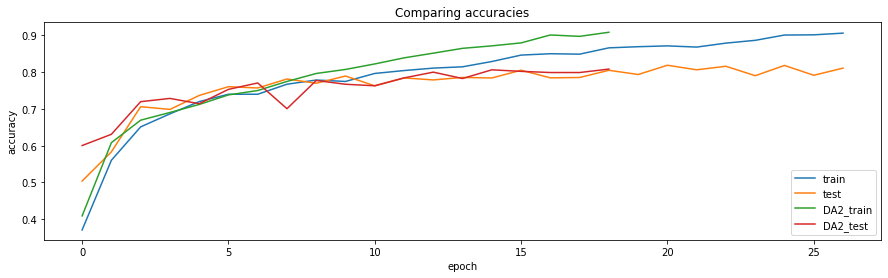

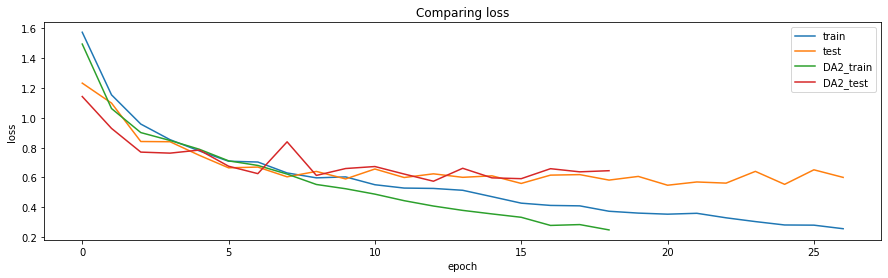

In [ ]:
plt.figure(figsize=(15, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_DA2.history['accuracy'])
plt.plot(history_DA2.history['val_accuracy'])
plt.legend(['train', 'test', 'DA2_train', 'DA2_test'], loc='lower right')
plt.title('Comparing accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

plt.figure(figsize=(15, 4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_DA2.history['loss'])
plt.plot(history_DA2.history['val_loss'])
plt.legend(['train', 'test', 'DA2_train', 'DA2_test'], loc='upper right')
plt.title('Comparing loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Classify some random elements to test the model.

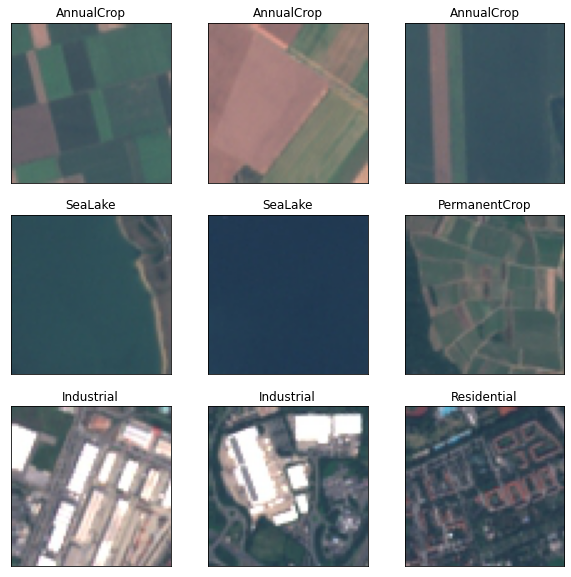

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model_DA2.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predict = model.predict(X_test)
print('Confusion Matrix and Report for model without DA')
print(confusion_matrix(y_test, predict.argmax(axis=1)))
print(classification_report(y_test, predict.argmax(axis=1)))

print('Confusion Matrix and Report with some DA')
predict_DA = model_DA.predict(X_test)
print(confusion_matrix(y_test, predict_DA.argmax(axis=1)))
print(classification_report(y_test, predict_DA.argmax(axis=1)))

print('Confusion Matrix and Report with remaining DA')
predict_DA2 = model_DA2.predict(X_test)
print(confusion_matrix(y_test, predict_DA2.argmax(axis=1)))
print(classification_report(y_test, predict_DA2.argmax(axis=1)))

Confusion Matrix and Report for model without DA
[[1745   15   28   74    0  120  109    1  141   17]
 [   0 2177   19    3    0   37    0    0   13    1]
 [  24   15 1658   63   62   51  218  119   33    7]
 [  54    7   88 1110  126   33  145  103  209    0]
 [   0    0    4   15 1789    0    9   56    2    0]
 [   5   44   43   40    0 1236   79    1   51    1]
 [  68    0  244  152   40   31 1284   18   38    0]
 [   0    0    6    6   49    0    0 2189    0    0]
 [  48   32   32  269   21   73   33    4 1359    4]
 [  23  104    9    1    0   41    0    0   37 2035]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2250
           1       0.91      0.97      0.94      2250
           2       0.78      0.74      0.76      2250
           3       0.64      0.59      0.62      1875
           4       0.86      0.95      0.90      1875
           5       0.76      0.82      0.79      1500
           6       0.68      0.68      0.

# Exercise 1

Create new `X_train` and `y_train` datasets, called `X_train_allDA_Pasture` and `y_train_allDA_Pasture` containing all the previously indicated DA techniques:

* Rotation
* Flip
* Zoom
* Contrast
* Brightness
* Hue

You should apply only one DA technique to each sample of the class `Pasture`. Create a classification model similar to the previous ones, showing similar reports (`accuraccy` and `loss` graphics, plus `confusion matrix` and `classification reports`).  

## Create Pasture base

2000 [16500, 16501, 16502, 16503, 16504, 16505, 16506, 16507, 16508, 16509, 16510, 16511, 16512, 16513, 16514, 16515, 16516, 16517, 16518, 16519, 16520, 16521, 16522, 16523, 16524, 16525, 16526, 16527, 16528, 16529, 16530, 16531, 16532, 16533, 16534, 16535, 16536, 16537, 16538, 16539, 16540, 16541, 16542, 16543, 16544, 16545, 16546, 16547, 16548, 16549, 16550, 16551, 16552, 16553, 16554, 16555, 16556, 16557, 16558, 16559, 16560, 16561, 16562, 16563, 16564, 16565, 16566, 16567, 16568, 16569, 16570, 16571, 16572, 16573, 16574, 16575, 16576, 16577, 16578, 16579, 16580, 16581, 16582, 16583, 16584, 16585, 16586, 16587, 16588, 16589, 16590, 16591, 16592, 16593, 16594, 16595, 16596, 16597, 16598, 16599, 16600, 16601, 16602, 16603, 16604, 16605, 16606, 16607, 16608, 16609, 16610, 16611, 16612, 16613, 16614, 16615, 16616, 16617, 16618, 16619, 16620, 16621, 16622, 16623, 16624, 16625, 16626, 16627, 16628, 16629, 16630, 16631, 16632, 16633, 16634, 16635, 16636, 16637, 16638, 16639, 16640, 16641, 

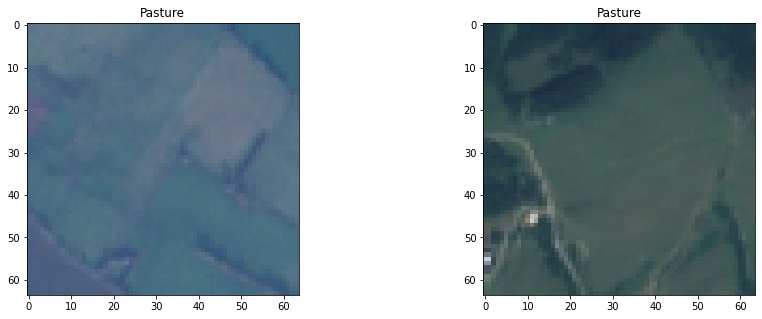

In [ ]:

idxs_pasture = [i for i, x in enumerate(labels) if x == 'Pasture'] 
print(len(idxs_pasture), idxs_pasture)

first_pasture_idx = idxs_pasture[0]
last_pasture_idx = idxs_pasture[len(idxs_pasture)-1]

plt.figure(figsize=(15, 5))

index = first_pasture_idx
plt.subplot(121)
plt.imshow(XImages[index])
plt.title(labels[index])

index = last_pasture_idx
plt.subplot(122)
plt.imshow(XImages[index])
plt.title(labels[index])

plt.show()

XImages_pasture = XImages[first_pasture_idx: last_pasture_idx+1]
yLabels_pasture_DA = np.array([9] * len(idxs_pasture))

## DA with one technique for each pasture image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 720x720 with 0 Axes>

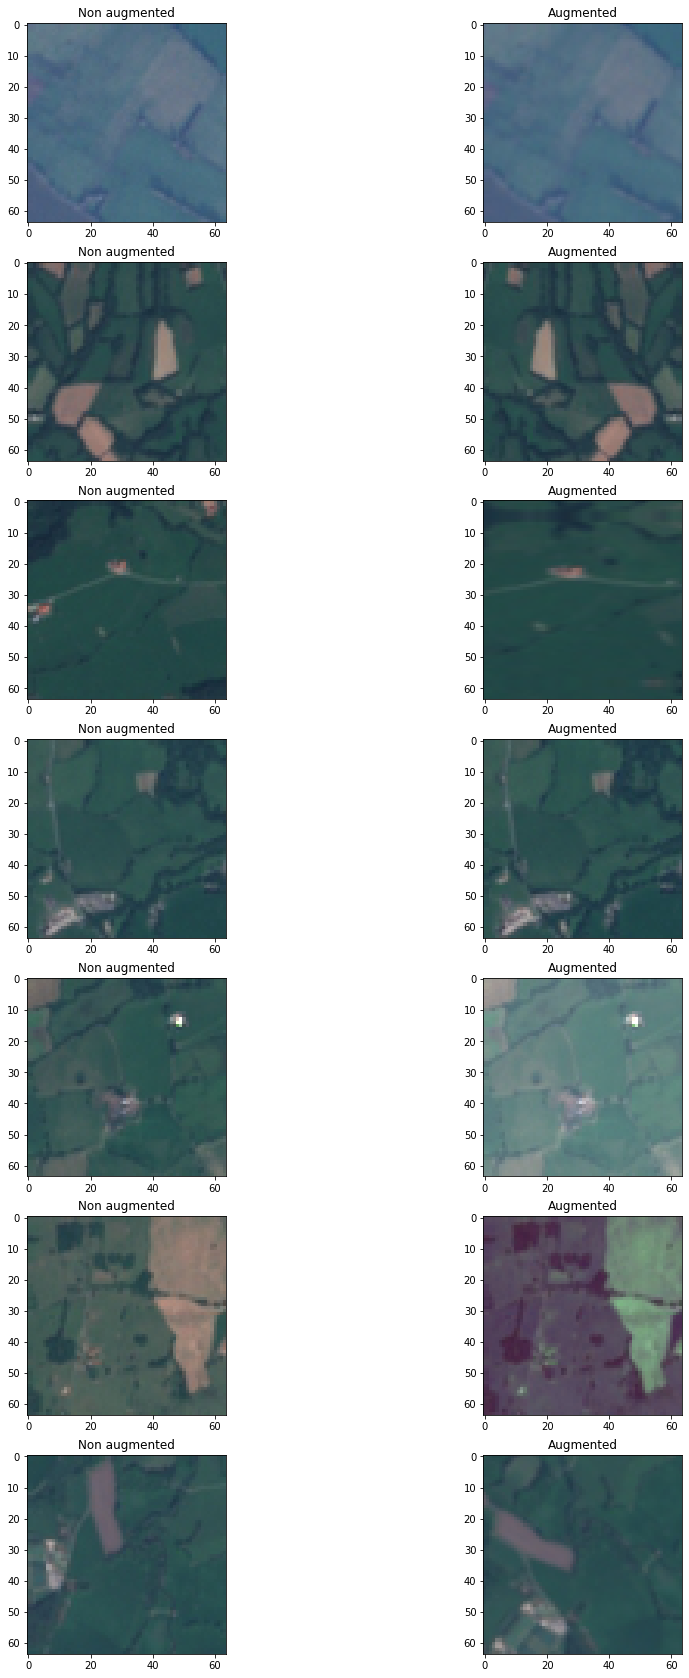

In [ ]:
XImages_pasture_DA = XImages_pasture.copy() 

factor_contrast = 0.3
factor_hue = 0.5
seed_hue = (1, 2)

plt.figure(figsize=(10, 10))
for i in range(XImages_pasture.shape[0]):
  if i%6 == 0:
    XImages_pasture_DA[i] = DA_rotation(XImages_pasture[i])
  elif i%6 == 1:
    XImages_pasture_DA[i] = DA_flip(XImages_pasture[i])
  elif i%6 == 2:
    XImages_pasture_DA[i] = DA_zoom(XImages_pasture[i])
  elif i%6 == 3:
    XImages_pasture_DA[i] = DA_contrast(XImages_pasture[i])
  elif i%6 == 4:
    delta = factor_contrast * np.random.rand()
    XImages_pasture_DA[i] = tf.image.adjust_brightness(XImages_pasture[i], delta)
  elif i%6 == 5:
    delta = factor_hue * np.random.rand()
    XImages_pasture_DA[i] = tf.image.stateless_random_hue(XImages_pasture[i], delta, seed_hue)


plt.figure(figsize=(15, 30))
counter = 1
samps = 7
for i in range(samps):

  plt.subplot(samps, 2, counter)
  plt.title('Non augmented')
  plt.imshow(XImages_pasture[i])
  plt.subplot(samps, 2, counter + 1)
  plt.title('Augmented')
  plt.imshow(XImages_pasture_DA[i])

  counter += 2

## Creating train test bases

In [ ]:
X_train_allDA_Pasture = np.concatenate((X_train, XImages_pasture_DA))
y_train_allDA_Pasture = np.concatenate((y_train, yLabels_pasture_DA))

print('len(X_train):', len(X_train_allDA_Pasture), 'len(y_train):', len(y_train_allDA_Pasture))
print('len(X_test):', len(X_test_allDA_Pasture), 'len(y_test):', len(y_test_allDA_Pasture))

len(X_train): 8750 len(y_train): 8750
len(X_test): 21750 len(y_test): 21750


## Compare CNN with Original x DA for Pasture

In [ ]:
num_classes = len(label_dictionary)
model_allDA_Pasture = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    restore_best_weights = True)

model_allDA_Pasture.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_allDA_Pasture = model_allDA_Pasture.fit(
  X_train_allDA_Pasture, y_train_allDA_Pasture,
  epochs = epochs,
  callbacks = early_stop,
  validation_data = (X_test, y_test) )

Epoch 1/30
274/274 [==============================] - 4s 12ms/step - loss: 1.5691 - accuracy: 0.4283 - val_loss: 1.5952 - val_accuracy: 0.4078
Epoch 2/30
274/274 [==============================] - 2s 8ms/step - loss: 1.2298 - accuracy: 0.5510 - val_loss: 1.1790 - val_accuracy: 0.5548
Epoch 3/30
274/274 [==============================] - 2s 8ms/step - loss: 1.0498 - accuracy: 0.6279 - val_loss: 1.0737 - val_accuracy: 0.5863
Epoch 4/30
274/274 [==============================] - 2s 8ms/step - loss: 0.9381 - accuracy: 0.6637 - val_loss: 0.9487 - val_accuracy: 0.6359
Epoch 5/30
274/274 [==============================] - 2s 8ms/step - loss: 0.8873 - accuracy: 0.6827 - val_loss: 0.8863 - val_accuracy: 0.6442
Epoch 6/30
274/274 [==============================] - 2s 8ms/step - loss: 0.8089 - accuracy: 0.7050 - val_loss: 0.8391 - val_accuracy: 0.6759
Epoch 7/30
274/274 [==============================] - 2s 8ms/step - loss: 0.7812 - accuracy: 0.7217 - val_loss: 0.9627 - val_accuracy: 0.6262
Epoch

Lets compare the plots of accuracy and loss along the epochs, without and with DA.

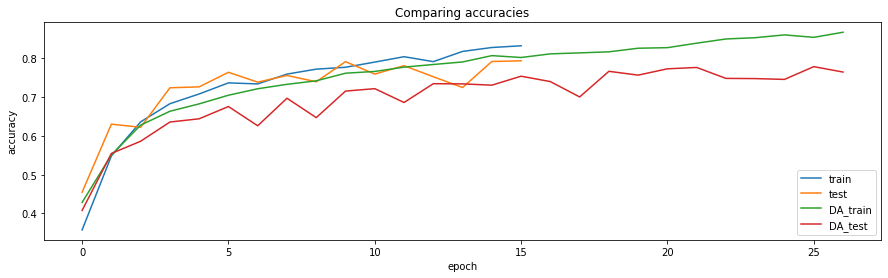

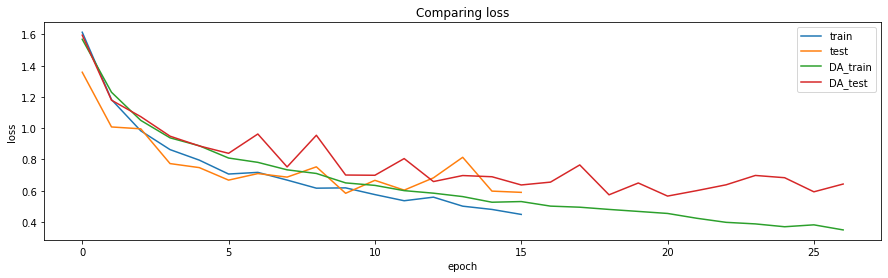

In [ ]:
plt.figure(figsize=(15, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_allDA_Pasture.history['accuracy'])
plt.plot(history_allDA_Pasture.history['val_accuracy'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='lower right')
plt.title('Comparing accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

plt.figure(figsize=(15, 4))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_allDA_Pasture.history['loss'])
plt.plot(history_allDA_Pasture.history['val_loss'])
plt.legend(['train', 'test', 'DA_train', 'DA_test'], loc='upper right')
plt.title('Comparing loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

Classify some random elements to test the model.

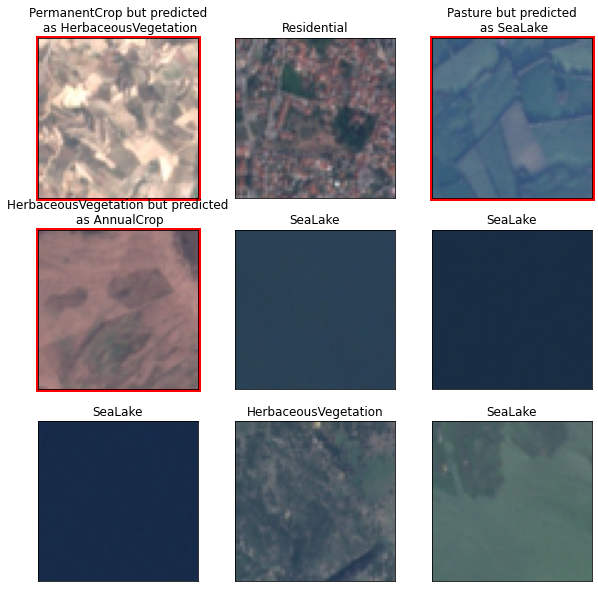

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  index = np.random.randint(0, len(X_test))
  input_image = X_test[index]
  input_image = tf.expand_dims(input_image, 0)
  # input_image = tf.reshape(X_test[index], (-1, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
  label = y_test[index]
  prediction = model_DA.predict(input_image)

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[index])
  plt.xticks([]), plt.yticks([])
  if label == prediction.argmax():
    plt.title(label_dictionary[label])
  else:
    ax.patch.set_edgecolor('red')  
    ax.patch.set_linewidth('5')
    plt.title(label_dictionary[label] + ' but predicted\n as ' + label_dictionary[prediction.argmax()])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predict = model.predict(X_test)
print('Confusion Matrix and Report for model without DA')
print(confusion_matrix(y_test, predict.argmax(axis=1)))
print(classification_report(y_test, predict.argmax(axis=1)))

print('Confusion Matrix and Report with all DA for pasture')
predict_allDA_pasture = model_allDA_Pasture.predict(X_test)
print(confusion_matrix(y_test, predict_allDA_pasture.argmax(axis=1)))
print(classification_report(y_test, predict_allDA_pasture.argmax(axis=1)))

Confusion Matrix and Report for model without DA
[[1930   15   49   31    0   79   89    1   40   16]
 [   0 1962   44    2    0  186    0    0   10   46]
 [  71   13 1664   43   24   32  227  108   57   11]
 [ 130    6  133  936   63   56  212  101  238    0]
 [   1    0   25   31 1705    0   13   95    5    0]
 [  38   16  106   18    0 1228   54    0   38    2]
 [ 131    1  364  118   21   29 1170   13   28    0]
 [   0    0   43   17   26    0    3 2160    1    0]
 [ 110   53   50  236    6  111   39    1 1259   10]
 [  48   70   13    0    0   63    0    0   38 2018]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2250
           1       0.92      0.87      0.89      2250
           2       0.67      0.74      0.70      2250
           3       0.65      0.50      0.57      1875
           4       0.92      0.91      0.92      1875
           5       0.69      0.82      0.75      1500
           6       0.65      0.62      0.

# References

[chollet2018] **Deep Learning with Phyton**. François Chollet. https://livebook.manning.com/book/deep-learning-with-python/

[tensorflow2021images] https://www.tensorflow.org/tutorials/load_data/images

[tensorflow2021da] https://www.tensorflow.org/tutorials/images/data_augmentation